# Part 2: Complete example with low-level APIs

In this part of the tutorial, we will implement a simple model, the appropriate loss function, gradient descent for optimization, and a simple training loop from scratch. 
<bl>
In practice, you will often use higher-level APIs to do save some coding. 
But to understand what these high-level APIs do, we will first need to get our hands dirty with low-level API once again.

In [ ]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import numpy as np

## Data

In [19]:
data = input_data.read_data_sets("data/MNIST/", one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [2]:
print("The dataset is already split into training, validation and testing:")
print("Train:\t{}".format(len(data.train.labels)))
print("Val:\t{}".format(len(data.validation.labels)))
print("Test:\t{}".format(len(data.test.labels)))

The dataset is already split into training, validation and testing:
Train:	55000
Val:	5000
Test:	10000


In [3]:
# We can extract *random* batches from the training data as follows
batch_inputs, batch_targets = data.train.next_batch(batch_size=42)
print("inputs shape: {}".format(batch_inputs.shape))
print("targets shape: {}".format(batch_targets.shape))

inputs shape: (42, 784)
targets shape: (42, 10)


target: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


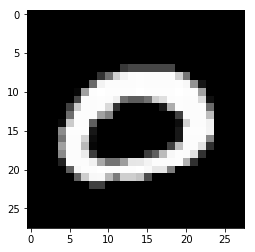

In [4]:
# Lets plot a random sample input and target from the batch.
idx = 0  
plt.figure()
plt.imshow(np.reshape(batch_inputs[idx], [28, 28]), cmap='gray')
print("target: {}".format(batch_targets[idx]))

## Model

In [5]:
class LinearModel():
    def __init__(self, dim_in, dim_out):
        # Note: Ignore these initializers for now, we will discuss them later when we build Neural Networks.
        weights_initializer = tf.initializers.variance_scaling(scale=1.0, mode="fan_in", distribution="Normal")
        bias_initializer = tf.initializers.constant(0.0)  # Bias can be initialized with all zeros

        self.weights = tf.get_variable(shape=[dim_in, dim_out], name="weights", initializer=weights_initializer)
        self.biases = tf.get_variable(shape=[dim_out], name="biases", initializer=bias_initializer)
        
    def __call__(self, inputs):
        outputs = tf.add(self.biases, tf.matmul(inputs, self.weights))
        return outputs
    
class MLP():
    def __init__(self, dim_in, dims_hidden, dim_out):
        # Note: Ignore these initializers for now, we will discuss them later when we build Neural Networks.
        weights_initializer = tf.initializers.variance_scaling(scale=1.0, mode="fan_in", distribution="Normal")
        bias_initializer = tf.initializers.constant(0.0)  # Bias can be initialized with all zeros
        
        self.num_layers = len(dims_hidden) + 1
        
        dims_in = [dim_in] + list(dims_hidden)
        dims_out = list(dims_hidden) + [dim_out]
        self.weights, self.biases = list(), list()
        for idx_layer, (dim_in, dim_out) in enumerate(zip(dims_in, dims_out)):
            self.weights.append(tf.get_variable(
                shape=[dim_in, dim_out], 
                name="weights_{}".format(idx_layer), 
                initializer=weights_initializer))
            self.biases.append(tf.get_variable(
                shape=[dim_out], 
                name="biases_{}".format(idx_layer), 
                initializer=bias_initializer
            ))
            
    def __call__(self, inputs):
        x = inputs
        for idx_layer in range(self.num_layers):
            x = tf.add(self.biases[idx_layer], tf.matmul(x, self.weights[idx_layer]))
            if not idx_layer == self.num_layers - 1:  # last layer
                x = tf.nn.relu(x)
        return x

In [6]:
# images have 28*28 pixels. Targets 0-9 (categorical variable with 10 possible values)
dim_in, dim_out = 784, 10
batch_size = 128

**Task 1 - Implement function**: Our model simply calculates a linear transformation of the inputs. 
The outputs can be interpreted as "logits", which are the logarithms of the unnormalized probabilities of our K=10 categories. 
<br>
A common approach in (Bayesian) machine learning is to maximize the log-probability of the observed data under the model (likelihood principle). 
Equivalently, we minimize the cross-entropy between the observed and model distribution.
<br>
For categorical data, the data distribution is simply a dirac or "one-hot" distribution.

To calculate the log-probabilities, you will need to
<br>
a) transform the output into a probability distribution 
<br>
b) calculate the cross-entropy. 
<bl>
**Hint**: The cross entropy (negative log-likelihood) is defined as follows:
<br>
$H(p_{\text{data}}, p_{\text{model}}) = \sum_{k=1}^{K} p_{\text{data}}(y_{k}) \cdot (- \log p_{\text{model}}(y_k))$ 

In [7]:
# TODO: This shall be a task. Hide the solutions.
# To complete both functions, you will need the following tf functions: 
# tf.cast, tf.reduce_sum, tf.argmax, tf.equal, tf.nn.softmax, tf.log

def get_categorical_log_prob(logits, labels):
    probs = tf.nn.softmax(logits)
    labels = tf.cast(labels, tf.float32)
    log_prob = tf.reduce_sum(labels * tf.log(probs + 1e-8), axis=-1)
    return log_prob

def get_accuracy(logits, labels):
    correct_prediction = tf.equal(tf.argmax(logits, axis=-1), tf.argmax(labels, axis=-1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

In [8]:
tf.reset_default_graph()  # Might be helpful, if you rebuild your model.
labels = tf.placeholder(shape=[batch_size, dim_out], dtype=tf.int32, name="targets")
inputs = tf.placeholder(shape=[batch_size, dim_in], dtype=tf.float32, name="inputs")
#model = LinearTransformModel(dim_in=dim_in, dim_out=dim_out)
model = MLP(dim_in=dim_in, dims_hidden=[128, 128], dim_out=dim_out)
logits = model(inputs) 

In [9]:
log_prob = get_categorical_log_prob(logits, labels)
loss = - tf.reduce_sum(log_prob, axis=0)  # Maximize sum of *negative* log-probabilities. 
accuracy = get_accuracy(logits, labels)

In [10]:
def gradient_descent_step(loss, variables, learning_rate):
    gradients = tf.gradients(loss, variables)
    var_updates = []
    for grad, var in zip(gradients, variables):
        step = var.assign_sub(learning_rate * grad)  # GD step of one single variable
        var_updates.append(step)
    gradient_descent_step_op = tf.group(*var_updates)  # all GD step operations grouped into one op.
    return gradient_descent_step_op

In [11]:
train_op = gradient_descent_step(loss, tf.global_variables(), 0.001)

In [12]:
train_losses, val_losses = [], []
max_iter = 20000

sess = tf.Session()
sess.run(tf.global_variables_initializer()) # Initializes weights and biases.

for iter_train in range(max_iter):  # Do 10k iterations of gradient descent
    batch_inputs, batch_labels = data.train.next_batch(batch_size=batch_size)
    feed_dict = {inputs: batch_inputs, labels: batch_labels}
    _, train_loss_iter = sess.run([train_op, loss], feed_dict=feed_dict)  
    train_losses.append(train_loss_iter)
    if iter_train % 1000 == 0:
        print("iteration {} of {}".format(iter_train, max_iter))

iteration 0 of 20000
iteration 1000 of 20000
iteration 2000 of 20000
iteration 3000 of 20000
iteration 4000 of 20000
iteration 5000 of 20000
iteration 6000 of 20000
iteration 7000 of 20000
iteration 8000 of 20000
iteration 9000 of 20000
iteration 10000 of 20000
iteration 11000 of 20000
iteration 12000 of 20000
iteration 13000 of 20000
iteration 14000 of 20000
iteration 15000 of 20000
iteration 16000 of 20000
iteration 17000 of 20000
iteration 18000 of 20000
iteration 19000 of 20000


In [13]:
num_samples_test = 10000
test_losses, test_accuracies = list(), list()
test_inputs, test_labels = data.test.images, data.test.labels
for iter_test in range(int(num_samples_test / batch_size)):  # Do 10k iterations of gradient descent
    batch_inputs = test_inputs[iter_test*batch_size:(iter_test+1)*batch_size]
    batch_labels = test_labels[iter_test*batch_size:(iter_test+1)*batch_size]
    feed_dict = {inputs:batch_inputs, labels: batch_labels}
    test_loss_iter, test_accuracy_iter = sess.run([loss, accuracy], feed_dict=feed_dict)
    test_losses.append(test_loss_iter)
    test_accuracies.append(test_accuracy_iter)
test_accuracy = np.mean(test_accuracies)
print("Test accuracy is: {}".format(test_accuracy))
print(np.mean(test_losses))

Test accuracy is: 0.9786658883094788
11.291608


# Short recap

The obrained accuracy is rather bad for this simple dataset. 
However, this was not the point of this tutorial. 
We chose a very simple model (linear) and used plain SGD for just a few (20k) training steps.

We have implemented our model, loss, and optimization algorithm with the low-level tensorflow APIs. 
However, tensorflow also provides some very useful high-level APIs.
<br>
In the next tutorial, we will explore some of these APIs.